  0%|          | 0/468 [00:00<?, ?it/s]

Epochs: 10
Batch size: 128
Batches per epoch: 468.75
--------------- Epoch 1 ---------------


  0%|          | 2/468 [00:00<00:33, 13.96it/s]

--------------- Epoch 2 ---------------


  0%|          | 2/468 [00:00<00:35, 13.05it/s]

--------------- Epoch 3 ---------------


  0%|          | 1/468 [00:00<00:56,  8.24it/s]

--------------- Epoch 4 ---------------


  0%|          | 1/468 [00:00<00:48,  9.57it/s]

--------------- Epoch 5 ---------------


  0%|          | 1/468 [00:00<01:00,  7.74it/s]

--------------- Epoch 6 ---------------


  0%|          | 1/468 [00:00<01:04,  7.26it/s]

--------------- Epoch 7 ---------------


  0%|          | 1/468 [00:00<00:53,  8.69it/s]

--------------- Epoch 8 ---------------


  0%|          | 1/468 [00:00<00:57,  8.11it/s]

--------------- Epoch 9 ---------------


  0%|          | 1/468 [00:00<00:52,  8.90it/s]

--------------- Epoch 10 ---------------


100%|██████████| 468/468 [01:00<00:00,  7.90it/s]


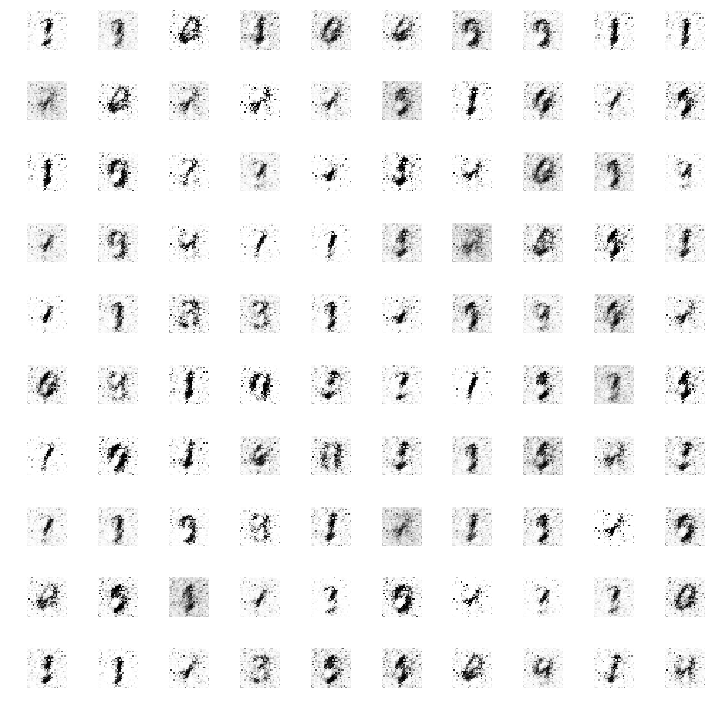

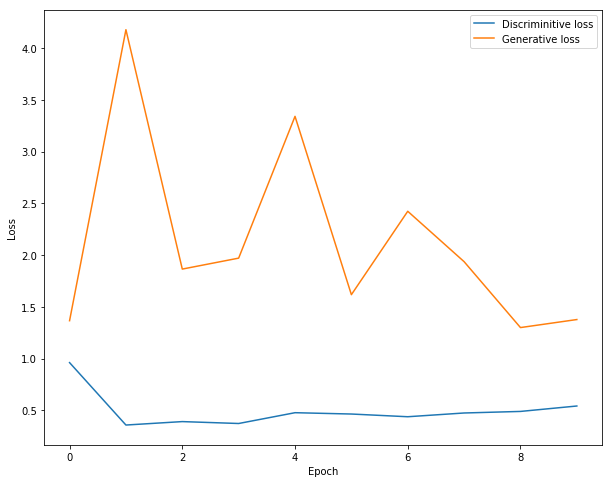

In [6]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

K.set_image_dim_ordering('th')

# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)

# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 100

# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(60000, 784)

# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

generator = Sequential()
generator.add(Dense(256, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)

discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

# Combined network
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

dLosses = []
gLosses = []

# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/gan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images/gan_generated_image_epoch_%d.png' % epoch)

# Save the generator and discriminator networks (and weights) for later use
def saveModels(epoch):
    generator.save('models/gan_generator_epoch_%d.h5' % epoch)
    discriminator.save('models/gan_discriminator_epoch_%d.h5' % epoch)

def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] / batchSize
    print('Epochs:', epochs)
    print('Batch size:', batchSize)
    print('Batches per epoch:', batchCount)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(int(batchCount))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        if e == 1 or e % 20 == 0:
            plotGeneratedImages(e)
            saveModels(e)

    # Plot losses from every epoch
    plotLoss(e)

if __name__ == '__main__':
    train(10, 128)



In [9]:
model_json = discriminator.to_json()
with open("models/gan10epochs.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
discriminator.save_weights("models/modelGAN10epochs.h5")
print("Saved model to disk")

Saved model to disk
